Up to now, the findings:

# Openstreetmap Case Study
- <a href='#map_area'>Map Area</a>
- <a href='#problems'>Problems Encounted in the Map</a>
- <a href='#data_overview'>Data Overview</a>
- <a href="#explore1">Explore Part I: Users, Contributions and Versions</a>
- <a href="#explore2">Explore Part II: Tags Related</a>



<a id = 'map_area'></a>
## Map Area

Beijing, China
- http://www.openstreetmap.org/relation/912940#map=8/40.256/116.461
- https://mapzen.com/data/metro-extracts/metro/beijing_china/

This map is of the city that I've lived in for a few years, and I'm familiar with its geographical information. 

<a id = 'problems'></a>
## Problems Encounted in the Map
After I downloaded this dataset, I took a sample from this dataset(i.e., `sample_divide_by10.osm`), since the original one(i.e., `beijing_china.osm`) is a little huge. Then I imported the raw sample data to sqlite and queried for 30 most common tags in the `nodes_tags` database. By looking through the most common tags in the sample osm file, I got a rough understanding about the dataset. Also, I went to the forum to get inspiration about the problems other people encounted in their dataset.

Here are some problems I encounted in the map. The first three problems are handled in this analysis.
- incorrect postcodes, since postcodes for Beijing is 6 digit long, some postcodes are less than 6 digit, like '10060', '10040', '1111' and etc
- unconsistent phone numbers, some are in the format of the international area code(i.e., 86 or 0086 or +86) plus phone number, some are in the format of domestic area code(i.e., 010 or 10) plus phone number, some are with both, and many only have 8 digit phone number.
- a few tags with the key "FIXME" or "fixme", underlying some information with the node needs to change later.
- opening hours are unconsistent, like "24/7" and "Mo-Su 05:00-23:00" and etc.
- specific problems: like `<tag k="opening_hours" v="高碑店街道便民服务中心" />`, key and value don't match here.




### Incorrect postcodes
First, I collected all incorrect postcodes. A postcode for area in Beijing was considered right when it was 6-digit long and started with '10'.
```python
def audit_postcode(uncorrect_postcodes, postcode_value):
	if len(postcode_value) == 6:
		if postcode_value.startswith('10'):
			return True
	uncorrect_postcodes[postcode_value] += 1
	return False
```
Incorrect postcodes in this dataset had only 11 records, and this was no pattern in incorrect postcodes. So I decided to modify them manually according to sibling tags, but there are still 3 incorrect postcode reacord omitted. 
```python
def update_postcode(postcode, mapping):
	if postcode in mapping:
		modified_postcode = mapping[postcode]
		return modified_postcode
	else:
		return None 
```



### Unconsistent phone numbers
As described above, phone numbers were in different format. Below are a few typical ones.
- 010-84477300: with domestic area code for Beijing 010
- 64359561: telephone number
- 01067654321
- +861066069281: with international area code for China 86 and domestic area code for Beijing 10 (0 are omitted here)
- 15601077881: mobile phone number

And I want to make the phone numbers conform to the same format, '010-xxxxxxxx' for telephone number and '1xxxxxxxxxx' for mobile phone numbers. So I used regular expressions to finish this task, brackets or '-' are removed first, then the real phone numbers are taken out using the regular expressions. In this process, incorrect phone numbers that has less or more digit would be dropped. Actually, when doing this, I found a few correct records were removed because of their formatting issue.
```python
phone_number_re = re.compile(r'^((00)?86)?(0?10)?(\d{8})$', re.IGNORECASE)
mobile_phone_number_re = re.compile(r'^((00)?86(10)?)?(1\d{10})$', re.IGNORECASE)
def clean_phone_number(phone): 
# incorrect_phone_numbers will be dropped, while others need to conform to consistency
	phone_number = re.sub(r'\D', "", phone)
	m = phone_number_re.search(phone_number)
	n = mobile_phone_number_re.search(phone_number)
	if m:
		cleaned_phone_number = '010-' + m.group(4)
	elif n:
		cleaned_phone_number = n.group(4)
	else:
		cleaned_phone_number = None
	if cleaned_phone_number:
		print phone, '=>', cleaned_phone_number
	else:
		print phone, '=> omitted'
	return cleaned_phone_number 
```




<a id = 'data_overview'></a>
## Data Overview

This part gave an overview about this dataset, including the file sizes and the number of nodes, ways and tags.

### File sizes

- beijing_china.osm: 190 MB
- beijing_china.db: 99 MB
- nodes.csv： 71 MB
- nodes_tags.csv: 3.0 MB
- ways.csv: 7.6 MB
- ways_tags.csv: 25 MB
- ways_nodes.cv: 8.6 MB

### Number of nodes
```SQL
sqlite> select count(*) from nodes;
```
895431

### Number of ways
```SQL
sqlite> select count(*) from ways;
```
132814

### Number of tags
```SQL
sqlite> select sum(count)
from 
(select count(*) as count from nodes_tags 
union 
select count(*) as count from ways_tags);
```
346847

<a id="explore1"></a>
## Explore Part I: Users, Contributions and Versions

First, let's find how many contributions are made. Actually, that's the sum of node numbers and way numbers.

### Number of contributions
```SQL
sqlite> select sum(count) 
from
(select count(*) as count from nodes
union 
select count(*)as count from ways);
```
1028245

### Number of unique users
```SQL
sqlite> select count(distinct uid)
from
(select uid from nodes
union all
select uid from ways);
```
1934
### Top 10 Contributors
```SQL
sqlite> select user, count(*) as number
from
(select user from nodes
union all
select user from ways)
group by user
order by number desc
limit 10;
```
```sql
Chen Jia             237678
R438                 140711
hanchao              70683
Алекс Мок            66093
ij_                  51542
katpatuka            23406
m17design            22337
Esperanza36          18097
nuklearerWintersturm 15725
RationalTangle       13671
```

### Top10 contribution propotion
```SQL
select sum(number) 
from 
(select user, count(*) as number
from
(select user from nodes
union all
select user from ways)
group by user
order by number desc
limit 10);
```
659943

And we can easily figure out the top 10 contributors contributed about 64.2%. If we make similar query on top 20, then we can get the percentage for top20 is about 72.1%.(741418) 

### Number of single contribution
```SQL
sqlite> select count(*) from
(select user, count(*) as number
from
(select user from nodes
union all
select user from ways)
group by user
having number = 1);
```
483
Nearly a quarter people contributed once.


### Most Frequently Changed
I was curious to find which node or way changed most frequently. So I quried for the tags information about the node.
```SQL
select t1.id, t1.key, t1.value, t1.type
from 
(select * from nodes_tags
union all
select * from ways_tags) t1
join 
(select max(v), id
from
(select cast(version as int) as v, id from nodes
union all
select cast(version as int) as v, id from ways)) t2
on t1.id = t2.id;
```
Below is one segment about this node. It's the node describing the city. Not too surprised to get this result. When we quried for the version information, we got 88.
```
25248662|ref|京|regular
25248662|name|北京市|regular
25248662|rank|0|regular
25248662|place|city|regular
25248662|en|BJ|ref
25248662|vi|Kinh|ref
25248662|capital|yes|regular
25248662|DSG|ADM1|gns
25248662|UFI|-1898545|gns
25248662|UNI|9310007|gns
```
When we do another query, we could get that 840950 nodes or ways are of version 1, accounting for about 81.8% of the dataset.

```SQL
select count(*) as number
from
(select version from nodes
where version = '1'
union all
select version from ways
where version = '1');
```
840950

<a id="explore2"></a>
## Explore Part II: Tags Related
When transforming the osm data to csv files, we treated tags in the following way:
- When the key of the tag has no colon, like 'phone', then key is still itself and type is assigned to 'regular'.
- When the key of the tag has at least a colon, like 'addr:street', we split the value using the first colon index. The value of type is assigned to first part, and the left part was assigned to key.

So when trying to find the most frequently appeared tags, I dealed with them separately. When type equals 'regular', then I queried for the key. When type doesn't equal 'regular', then I would query for the type value.

### 1. Top 10 Tags
```SQL
sqlite> select kind, count(*) as number
from 
(select key as kind from nodes_tags where type = 'regular'
union all
select type as kind from nodes_tags where not type = 'regular'
union all
select key as kind from ways_tags where type = 'regular'
union all
select type as kind from ways_tags where not type = 'regular')
group by kind
order by number desc
limit 10;
```
We can see from the results that many tags are related to the traffic.
```
highway|78558
building|52463
name|49516
oneway|21057
power|14112
source|9981
public_transport|9875
railway|8088
layer|7998
bridge|7965
```


### 2. Land Use Situation in Beijing

Here, I would like to draw a pie chart to intuitively represent landuse condition in Beijing. We can see from the pie chart that almost a half of the land is used for residential.

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
%matplotlib inline

In [10]:
def retrieve_data_from_sqlite(query):
    db = sqlite3.connect('beijing_china.db')    
    cur = db.cursor()
    cur.execute(query)
    return cur.fetchall()

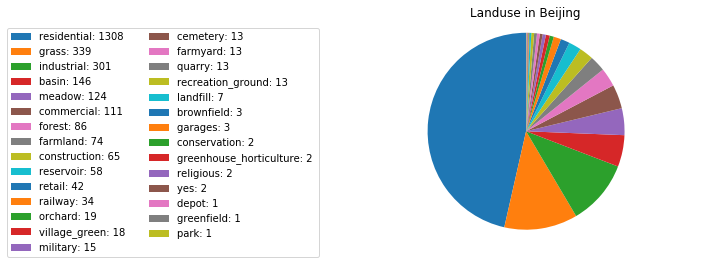

In [55]:
sql = """
select value, count(*) as number
from (select value from nodes_tags
where key = 'landuse'
union all
select value from ways_tags
where key = 'landuse')
group by value
order by number desc
"""
landuse = pd.DataFrame(retrieve_data_from_sqlite(sql))
patches, texts = plt.pie(landuse[1], startangle=90, radius=1.2)
plt.axis('equal')
plt.title('Landuse in Beijing')
labels = ['{0}: {1} '.format(i, j) for i,j in zip(landuse[0], landuse[1])]
plt.legend(patches, labels, loc='left center', bbox_to_anchor=(-0.1, 1.), fontsize=10, ncol=2)
# reference: 
# https://stackoverflow.com/questions/23577505/how-to-avoid-overlapping-of-labels-autopct-in-a-matplotlib-pie-chart

### 3. Data Source
I noticed there are many tags describing data source. So I would like to explore source distribution a little. But when  I looked at the result, I realized that the source data was quite dirty, including case sensitive issue, records with timestamp, Chinese characters included and etc, like `'Bing'`/`'bing'`/`'Bing imagery'`/`'Bing, 2005-04'`. So this field still needs later attention and cleaning.
```SQL
sqlite> select value, count(*) as number
from
(select value from nodes_tags
where key = 'source'
union all
select value from ways_tags
where key = 'source')
group by value
order by number desc;
```
But from above query, we could easily figure out that Bing is the biggest source. And we used the following sql to prove this. We can get that Bing acts as the biggest source, accounted for 81.75% in all source records.
```SQL
sqlite> select t2.bing_number * 1.0 / t1.total_number
from 
(select count(*) as total_number
from
(select value from nodes_tags
where key = 'source'
union all
select value from ways_tags
where key = 'source')) t1,
(select count(*) as bing_number
from
(select value from nodes_tags
where key = 'source' and lower(value) like '%bing%'
union all
select value from ways_tags
where key = 'source' and lower(value) like '%bing%')) t2;
```
81.75%



### 4. Number of universities
Beijing has many universities.

How to find a node is a university? By the relative tag: `<tag k="amenity" v="university" />`. So in database, a university will have a key named "amenity" and a value called "university". Both conditions need to be satisfied, since other tags may have value "university", like `<tag k="building" v="university" />`.
```SQL
sqlite> select count(*)
from nodes_tags
where key = 'amenity' and value = 'university'; 
```
11
```SQL
select count(*)
from
(select id
from nodes_tags
where key = 'amenity' and value = 'university'
union all
select id
from nodes_tags
where key = 'amenity' and value = 'college');
```

But the number is much smaller than it actually is. From [wiki](https://en.wikipedia.org/wiki/List_of_universities_and_colleges_in_Beijing), there are at least 70 establishments of higher education. Even when `<tag k="building" v="college" />` is considered, the number is only 25. So I think this dataset still has a lot to improve.


### 5. Number of tourism and its distribution
Since Beijing has many places of interest, I would like to know how many tourism sites are there in this city. 

```SQL
select count(distinct id)
from nodes_tags
where key = 'tourism';
```
1158

Also, I would want to figure out the distribution. Actually, not all tags with the key 'tourism' is a place of interest. From the below query result, hotels or motels are also included in this category. But there are 224 attration sites in Beijing, including the world well known Great Wall and others.

```SQL
sqlite> select value, count(*) as number
from nodes_tags
where key = 'tourism'
group by value
order by number desc
limit 5;
```
```
hotel|377
attraction|224
motel|167
viewpoint|67
artwork|64
```

### 6. Popular Food
```SQL
sqlite> select value, count(*) as number
from nodes_tags
where key = 'amenity'
group by value
order by number desc;
```
Here I would only show those with number above 50. Restaurants accounted for a considerable part.

```sql
restaurant|1431
bank|463
toilets|377
fast_food|347
cafe|302
parking|180
bar|165
school|160
telephone|151
atm|115
fuel|113
hospital|111
bicycle_rental|105
waste_basket|81
pharmacy|78
post_box|61
bench|51
```

 Next,  I would try to explore what kind of food are most popluar in Beijing except Chinese food.
 
```SQL
sqlite> select value, count(*) as number
from nodes_tags
where key = 'cuisine' and (not value = 'chinese')
group by value
order by number desc
limit 10;
```
Actually, this field is also quite dirty. Some values are a list of words, like `american;burger`. `pizza` and `pizza;american` are somewhat overlapped. But I have the confidence to say that fast foods are pretty popular including burger/pizza/sandwich/etc.

```sql
coffee_shop|61
chicken|55
american;burger|53
japanese|29
italian|20
pizza|15
pizza;american|15
regional|14
sandwich|14
burger|13
```

## Conclusions
There are pretty much to clean in this dataset. The following shows what I find during my exploration with this dataset.
- 

discover there are some chinese character keys(
```
应急避难场所总面积万平米|9
应急避难场所类别|9
应急避难场所类型|9
开发商|1
疏散人数(万人)|1
车库|1
黄南苑小区|1
```
)